In [67]:
import pandas as pd
import numpy as np
import os
import glob
import random
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [68]:
train = pd.read_csv('./data/train/train.csv')
sub = pd.read_csv('./data/sample_submission.csv')

In [69]:
def preprocess_data(data):
	temp = data.copy()
	return temp.iloc[-48:, :]

df_test = []

In [70]:
for i in range(81):
  file_path = './data/test/' + str(i) + '.csv'
  temp = pd.read_csv(file_path)
  temp = preprocess_data(temp)
  df_test.append(temp)

X_test = pd.concat(df_test)
#Attach padding dummy time series
X_test = X_test.append(X_test[-96:])
X_test.shape

(3984, 9)

In [71]:
##=======================Add Td, T-Td and GHI features
def Add_features(data):
  c = 243.12
  b = 17.62
  gamma = (b * (data['T']) / (c + (data['T']))) + np.log(data['RH'] / 100)
  dp = ( c * gamma) / (b - gamma)
  data.insert(1,'Td',dp)
  data.insert(1,'T-Td',data['T']-data['Td'])
  data.insert(1,'GHI',data['DHI'] + data['DNI'] * np.cos(((180 * (data['Hour']+1+data['Minute']/60) / 24) - 90)/180*np.pi))
  return data

In [72]:
train = Add_features(train)
X_test = Add_features(X_test)

df_train = train.drop(['Day','Hour','Minute'],axis=1)
df_test  = X_test.drop(['Day','Hour','Minute'],axis=1)

column_indices = {name: i for i, name in enumerate(df_train.columns)}

#Train and Validation split
n = len(train)
train_df = df_train[0:int(n*0.8)]
val_df   = df_train[int(n*0.8):]
test_df = df_test

# Normalization
num_features = train_df.shape[1]

train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df   =  (val_df - train_mean) / train_std
test_df  = (test_df - train_mean) / train_std

In [73]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    #Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
    #Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  def __repr__(self):
    return '\n'.join([
      f'Total window size: {self.total_window_size}',
      f'Input indices: {self.input_indices}',
      f'Label indices: {self.label_indices}',
      f'Label column name(s): {self.label_columns}'])


In [74]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # Manually. This way the tf.data.Datasets' are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [75]:
def make_dataset(self, data,is_train=True):
  data = np.array(data, dtype=np.float32)
  if is_train==True:
	  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data, targets=None, sequence_length=self.total_window_size, sequence_stride=1, shuffle=True, batch_size=256,)
  else:
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data, targets=None, sequence_length=self.total_window_size, sequence_stride=1, shuffle=False, batch_size=256,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [76]:
@property
def train(self):
  return self.make_dataset(self.train_df,is_train=True)

@property
def val(self):
  return self.make_dataset(self.val_df,is_train=True)

@property
def test(self):
  return self.make_dataset(self.test_df,is_train=False)


@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self,'_example', None)
  if result is None:
    #No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [77]:
def plot(self, model=None, plot_col='TARGET', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.',zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions',  c='#ff7f0e', s=64)
  if n == 0:
    plt.legend()
  plt.xlabel('Time [30m]')

WindowGenerator.plot = plot

In [78]:
#Set the data-set 24 hours input -> 48 hours output
w1 = WindowGenerator(input_width=48, label_width=96, shift = 96)

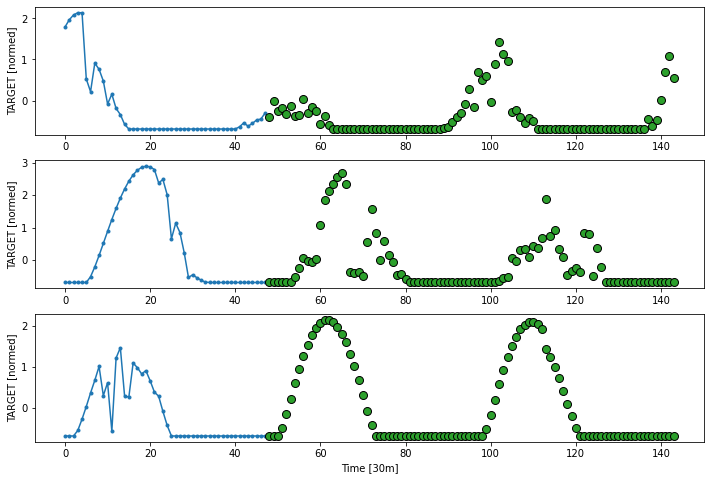

In [79]:
w1.plot()


In [43]:
w1.train.element_spec

(TensorSpec(shape=(None, 48, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 96, 10), dtype=tf.float32, name=None))

In [44]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (256, 48, 10)
Labels shape (batch, time, features): (256, 96, 10)


In [45]:
################# Quantile loss definition
def quantile_loss(q, y_true, y_pred):
	err = (y_true - y_pred)
	return K.mean(K.maximum(q*err, (q-1)*err), axis=-1)

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#########################
OUT_STEPS = 96

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')


In [47]:
########## quantile plot definition

def quantile_plot(self, model=None, plot_col='TARGET', max_subplots=3, quantile=None):
  inputs, labels = self.example
  if quantile == 0.1:
    plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    if quantile == 0.1:
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.',zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    if label_col_index is None:
      continue
    if quantile == 0.1:
      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=20)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='none', label=f'Predictions(q={quantile})', s=15)
    if quantile == 0.9 and n==0:
      plt.legend()
  plt.xlabel('Time [30m]')

WindowGenerator.quantile_plot = quantile_plot

In [48]:
def DenseModel():
  model = tf.keras.Sequential()
  model.add(L.Lambda(lambda x: x[:, -1:, :]))
  model.add(L.Dense(512, activation='relu'))
  model.add(L.Dense(256, activation='relu'))
  model.add(L.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros))
  model.add(L.Reshape([OUT_STEPS, num_features]))
  return model

Epoch 1/20
164/164 [==============================] - 2s 11ms/step - loss: 0.1692 - <lambda>: 0.1692 - val_loss: 0.0862 - val_<lambda>: 0.0862
Epoch 2/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0815 - <lambda>: 0.0815 - val_loss: 0.0799 - val_<lambda>: 0.0799
Epoch 3/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0770 - <lambda>: 0.0770 - val_loss: 0.0776 - val_<lambda>: 0.0776
Epoch 4/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0746 - <lambda>: 0.0746 - val_loss: 0.0758 - val_<lambda>: 0.0758
Epoch 5/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0732 - <lambda>: 0.0732 - val_loss: 0.0748 - val_<lambda>: 0.0748
Epoch 6/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0724 - <lambda>: 0.0724 - val_loss: 0.0751 - val_<lambda>: 0.0751
Epoch 7/20
164/164 [==============================] - 2s 11ms/step - loss: 0.0719 - <lambda>: 0.0719 - val_loss: 0.0739 - val_<lambda>: 0.0739

<ipython-input-47-30f937487139>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, n+1)


164/164 [==============================] - 3s 13ms/step - loss: 0.2631 - <lambda>: 0.2631 - val_loss: 0.1810 - val_<lambda>: 0.1810
Epoch 2/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1736 - <lambda>: 0.1736 - val_loss: 0.1670 - val_<lambda>: 0.1670
Epoch 3/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1626 - <lambda>: 0.1626 - val_loss: 0.1618 - val_<lambda>: 0.1618
Epoch 4/20
164/164 [==============================] - 2s 11ms/step - loss: 0.1580 - <lambda>: 0.1580 - val_loss: 0.1588 - val_<lambda>: 0.1588
Epoch 5/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1554 - <lambda>: 0.1554 - val_loss: 0.1573 - val_<lambda>: 0.1573
Epoch 6/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1536 - <lambda>: 0.1536 - val_loss: 0.1559 - val_<lambda>: 0.1559
Epoch 7/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1522 - <lambda>: 0.1522 - val_loss: 0.1544 - val_<lambda>: 0.1544
Epoch 8/20

164/164 [==============================] - 2s 10ms/step - loss: 0.1993 - <lambda>: 0.1993 - val_loss: 0.1875 - val_<lambda>: 0.1875
Epoch 3/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1849 - <lambda>: 0.1849 - val_loss: 0.1812 - val_<lambda>: 0.1812
Epoch 4/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1792 - <lambda>: 0.1792 - val_loss: 0.1774 - val_<lambda>: 0.1774
Epoch 5/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1761 - <lambda>: 0.1761 - val_loss: 0.1749 - val_<lambda>: 0.1749
Epoch 6/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1738 - <lambda>: 0.1738 - val_loss: 0.1737 - val_<lambda>: 0.1737
Epoch 7/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1724 - <lambda>: 0.1724 - val_loss: 0.1733 - val_<lambda>: 0.1733
Epoch 8/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1711 - <lambda>: 0.1711 - val_loss: 0.1720 - val_<lambda>: 0.1720
Epoch 9/20

41/41 [==============================] - 0s 6ms/step - loss: 0.1208 - <lambda>: 0.1208
Epoch 1/20
164/164 [==============================] - 2s 10ms/step - loss: 0.2071 - <lambda>: 0.2071 - val_loss: 0.1068 - val_<lambda>: 0.1068
Epoch 2/20
164/164 [==============================] - 2s 10ms/step - loss: 0.1024 - <lambda>: 0.1024 - val_loss: 0.0922 - val_<lambda>: 0.0922
Epoch 3/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0901 - <lambda>: 0.0901 - val_loss: 0.0864 - val_<lambda>: 0.0864
Epoch 4/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0847 - <lambda>: 0.0847 - val_loss: 0.0829 - val_<lambda>: 0.0829
Epoch 5/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0819 - <lambda>: 0.0819 - val_loss: 0.0812 - val_<lambda>: 0.0812
Epoch 6/20
164/164 [==============================] - 2s 10ms/step - loss: 0.0801 - <lambda>: 0.0801 - val_loss: 0.0802 - val_<lambda>: 0.0802
Epoch 7/20
164/164 [==============================] - 2

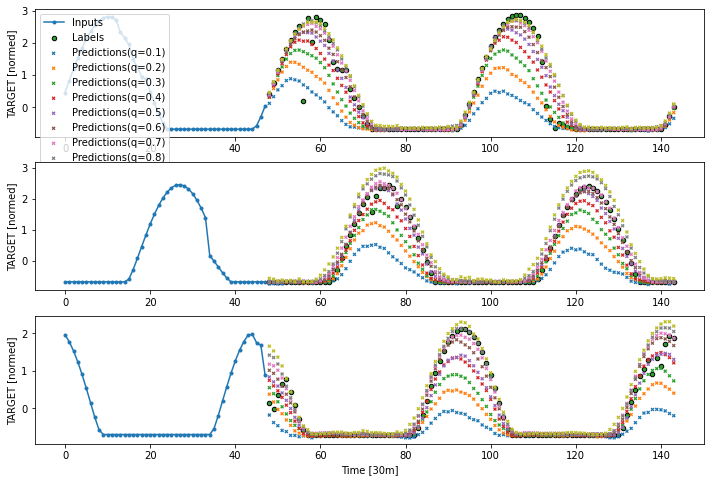

In [49]:
Dense_actual_pred = pd.DataFrame()
Dense_val_score = pd.DataFrame()

for q in quantiles:
	model = DenseModel()
	model.compile(loss = lambda y_true, y_pred: quantile_loss(q, y_true, y_pred), optimizer='adam', metrics=[lambda y, pred: quantile_loss(q, y, pred)])
	history = model.fit(w1.train, validation_data=w1.val, epochs=20, callbacks=[early_stopping])
	pred = model.predict(w1.test, verbose=0)
	target_pred = pd.Series(pred[::48][:,:,9].reshape(7776)) #Save predicted value (striding=48 step, 9 = TARGET) 
	Dense_actual_pred = pd.concat([Dense_actual_pred,target_pred],axis=1)
	Dense_val_score[f'{q}'] = model.evaluate(w1.val)
	w1.quantile_plot(model, quantile=q)

In [57]:
Dense_actual_pred.columns = quantiles
#Denormalizing TARGET values
Dense_actual_pred_denorm = Dense_actual_pred*train_std['TARGET'] + train_mean['TARGET']
#Replace Negative value to Zero
Dense_actual_pred_nn = np.where(Dense_actual_pred_denorm<0, 0, Dense_actual_pred_denorm)

sub.iloc[:,1:] = Dense_actual_pred_nn
sub.to_csv("./data/submission.csv",index=False)

In [58]:
### AutoRegressive LSTM
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [59]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)
  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [60]:
prediction, state = feedback_model.warmup(w1.example[0])
prediction.shape

TensorShape([256, 10])

In [61]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)
  # Insert the first prediction
  predictions.append(prediction)
  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)
  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Epoch 1/20
164/164 [==============================] - 57s 266ms/step - loss: 0.2323 - <lambda>: 0.2323 - val_loss: 0.1233 - val_<lambda>: 0.1233
Epoch 2/20
164/164 [==============================] - 41s 253ms/step - loss: 0.1186 - <lambda>: 0.1186 - val_loss: 0.1219 - val_<lambda>: 0.1219
Epoch 3/20
164/164 [==============================] - 40s 246ms/step - loss: 0.1175 - <lambda>: 0.1175 - val_loss: 0.1156 - val_<lambda>: 0.1156
Epoch 4/20
164/164 [==============================] - 40s 242ms/step - loss: 0.1086 - <lambda>: 0.1086 - val_loss: 0.1063 - val_<lambda>: 0.1063
Epoch 5/20
164/164 [==============================] - 39s 240ms/step - loss: 0.1033 - <lambda>: 0.1033 - val_loss: 0.1048 - val_<lambda>: 0.1048
Epoch 6/20
164/164 [==============================] - 39s 240ms/step - loss: 0.1020 - <lambda>: 0.1020 - val_loss: 0.1052 - val_<lambda>: 0.1052
Epoch 7/20
164/164 [==============================] - 40s 243ms/step - loss: 0.1015 - <lambda>: 0.1015 - val_loss: 0.1033 - val_<l

<ipython-input-47-30f937487139>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, n+1)


Epoch 1/20
164/164 [==============================] - 58s 267ms/step - loss: 0.1539 - <lambda>: 0.1539 - val_loss: 0.1529 - val_<lambda>: 0.1529
Epoch 2/20
164/164 [==============================] - 42s 255ms/step - loss: 0.1478 - <lambda>: 0.1478 - val_loss: 0.1539 - val_<lambda>: 0.1539
Epoch 3/20
164/164 [==============================] - 42s 254ms/step - loss: 0.1473 - <lambda>: 0.1473 - val_loss: 0.1513 - val_<lambda>: 0.1513
Epoch 4/20
164/164 [==============================] - 41s 253ms/step - loss: 0.1469 - <lambda>: 0.1469 - val_loss: 0.1518 - val_<lambda>: 0.1518
Epoch 5/20
164/164 [==============================] - 41s 253ms/step - loss: 0.1466 - <lambda>: 0.1466 - val_loss: 0.1504 - val_<lambda>: 0.1504
Epoch 6/20
164/164 [==============================] - 42s 253ms/step - loss: 0.1464 - <lambda>: 0.1464 - val_loss: 0.1505 - val_<lambda>: 0.1505
Epoch 7/20
41/41 [==============================] - 3s 68ms/step - loss: 0.1537 - <lambda>: 0.1537
Epoch 1/20
164/164 [===========

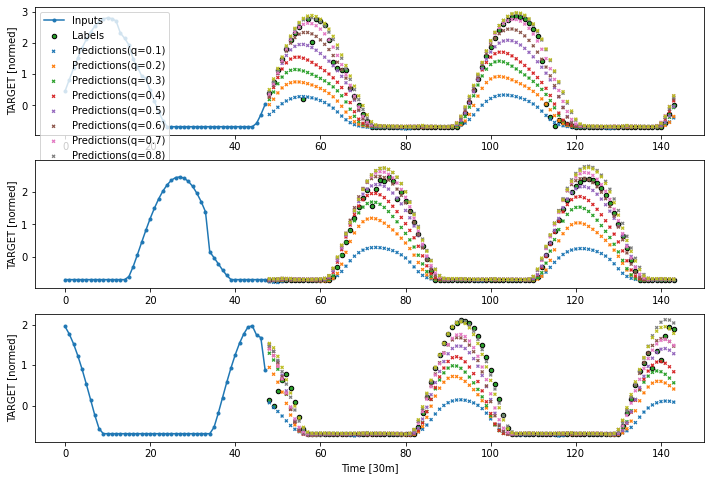

In [62]:
AR_Lstm_actual_pred = pd.DataFrame()
AR_Lstm_val_score = pd.DataFrame()

for q in quantiles:
        model = feedback_model
        model.compile(loss = lambda y_true, y_pred: quantile_loss(q, y_true, y_pred), optimizer='adam', metrics=[lambda y, pred: quantile_loss(q, y, pred)])
        history = model.fit(w1.train, validation_data=w1.val, epochs=20, callbacks=[early_stopping])
        pred = model.predict(w1.test, verbose=0)
        target_pred = pd.Series(pred[::48][:,:,9].reshape(7776))
        AR_Lstm_actual_pred = pd.concat([AR_Lstm_actual_pred,target_pred],axis=1)
        AR_Lstm_val_score[f'{q}'] = model.evaluate(w1.val)
        w1.quantile_plot(model, quantile=q)

In [63]:
AR_Lstm_actual_pred.columns = quantiles


In [64]:
AR_Lstm_actual_pred_denorm = AR_Lstm_actual_pred*train_std['TARGET'] + train_mean['TARGET']
AR_Lstm_actual_pred_nn = np.where(AR_Lstm_actual_pred_denorm<0, 0, AR_Lstm_actual_pred_denorm)

In [66]:
sub.iloc[:,1:] = AR_Lstm_actual_pred_nn
sub.to_csv("./data/submission.csv",index=False)